In [ ]:
from __future__ import print_function, division
import sys,os
    
import numpy as np # type: ignore

from quspin.operators import hamiltonian, exp_op, quantum_operator # type: ignore 
from quspin.basis import spinful_fermion_basis_1d # type: ignore
from quspin.tools.measurements import obs_vs_time # type: ignore
import matplotlib.pyplot as plt # type: ignore

font = {
        'weight' : 'bold',
        'size'   : 16}
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', **font) 

# the no-checks is just to avoid the printing of the message about Hermicity etc
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

Model parameters


In [9]:
L = 7
J = 1.0
U_0 = 0.0
V_0 = 0.0

U_f = 6
V_f = 0.0
tau = 5.0

# basis with symmetries
N = L//2
N_up = N + L%2
N_down = L - N_up

print("Nup = ", N_up,  "NDn = ", N_down)

basis = spinful_fermion_basis_1d(L,Nf=(N_up,N_down))
dim=basis.Ns

print("Size of 1D H-space: {Ns:d} \n".format(Ns=dim))
print(N, N_up, N_down)
# print(basis)

Nup =  4 NDn =  3
Size of 1D H-space: 1225 

3 4 3


Let's assume the system has open boundary conditions. So, to implement $\hat{H_0}$, we do:


In [10]:
'''
    Returns the structure for the time-independent part of 
    extended Hubbard Hamiltonian.

    - By default: open boundary conditions
'''
def EHM_Hamiltonian(L, U_0, V_0, J=1.0):
    
    hopping_right = [[-J, i, i+1] for i in range(L-1)]
    hopping_left  = [[+J, i, i+1] for i in range(L-1)]

    # Coulomb interaction
    on_site_interaction = [[U_0, i, i] for i in range(L)] 

    interact_v_right = [[V_0,i,i+1] for i in range(L-1)] # 
    interact_v_left = [[V_0,i+1,i] for i in range(L-1)] # 

    H_0 = [
        ['+-|', hopping_left],  # Hopping for spin-up
        ['-+|', hopping_right],
        ['|+-', hopping_left],  # Hopping for spin-down
        ['|-+', hopping_right],

        ['n|n', on_site_interaction],

        ['nn|',interact_v_right],   # up-up neighbor interaction
        ['|nn',interact_v_right],   # down-down neighbor interaction
        
        ['nn|',interact_v_left],   # up-up neighbor interaction
        ['|nn',interact_v_left],   # down-down neighbor interaction
        
        ['n|n',interact_v_right],   # up-down neighbor interaction
        ['n|n',interact_v_left],   # down-up neighbor interaction

    ]
    return H_0 
'''
    Ramp driving for V(t) or U(t).
'''
def Drive_Control(t, x_0, x_f, tau_x):
    t = min(t, tau_x)  # Clamp to tau_x
    return x_0 + np.abs(x_f - x_0) * (t/tau_x)
'''
    Returns the \\hat{U} time dependent part of the hamiltonian.
'''
def Quench_U(L, U_0, U_f, tau):
    driving_args = [U_0, U_f, tau]
    on_site_interaction_t = [[1.0,i,i] for i in range(L)] 
    U_t = [['n|n',on_site_interaction_t, Drive_Control, driving_args]]
    return U_t

In [11]:
H_0 = EHM_Hamiltonian(L, U_0, V_0, J=-1.0)

U_t = Quench_U(L, U_0, U_f, tau)

H_t = hamiltonian(H_0,U_t,basis=basis,dtype=np.float64, check_symm=False)

E_GS, Psi_GS = H_t.eigsh(time = 0, k=1, which='SA')

E_GS_tau, Psi_GS_tau = H_t.eigsh(time=tau, k=1, which='SA')

print(f'E_GS (t = 0): {E_GS}')
print(f'E_GS (t = tau): {E_GS_tau}')

Hermiticity check passed!
Particle conservation check passed!
E_GS (t = 0): [-8.05467898]
E_GS (t = tau): [-2.62593463]


In [ ]:
# the no-checks is just to avoid the printing of the message about Hermicity etc
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

N_t = 101
ts = np.linspace(0, tau, N_t)

Psi_ts = H_t.evolve(Psi_GS,ts[0],ts,rtol=1E-12,atol=1E-12, iterate=False)[:,0,:]

njUp_ts = np.zeros((N_t, L))
njDn_ts = np.zeros((N_t, L))

Sz_vals = np.zeros((N_t, L))

for j in range(L):
    NUpOp = hamiltonian([["n|",[[1.0, j]]]],[],basis=basis,**no_checks)
    NDnOp = hamiltonian([["|n",[[1.0, j]]]],[],basis=basis,**no_checks)
    NDoublons = hamiltonian([["n|n",[[1.0, j,j]]]],[],basis=basis,**no_checks)
    for it in range(N_t):
        NupNdn_t = obs_vs_time(Psi_ts[:,it].reshape(dim,1),ts[it],dict(Nup=NUpOp, Ndn=NDnOp), return_state=False)
        ket = Psi_ts[:,it].reshape(dim,1)
        
        njUp_ts[it,j] = NupNdn_t['Nup'][0].real
        njDn_ts[it,j] = NupNdn_t['Ndn'][0].real


charge_density = (njUp_ts + njDn_ts)
magnetization = (njUp_ts - njDn_ts) / 2 

In [13]:
njUp_tau = njUp_ts[-1, :]
njDn_tau = njDn_ts[-1, :]

charge_density_tau = charge_density[-1]
magnetization_tau = magnetization[-1]

[ 0.21099242 -0.10987376  0.211762   -0.1257613   0.211762   -0.10987376
  0.21099242]


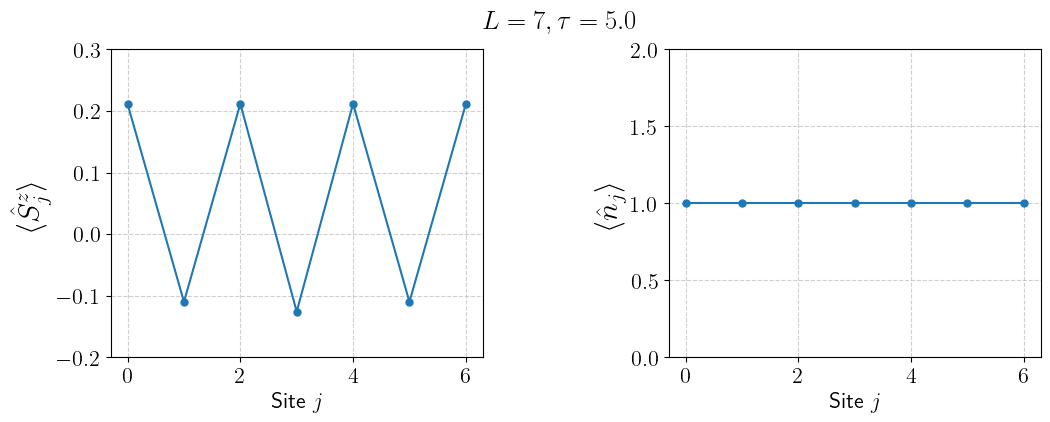

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

print(magnetization_tau)

# Connect points with lines
ax[0].plot(range(len(magnetization_tau)), magnetization_tau, '-o', markersize=5, linewidth=1.5, label=r'$m_j$')
ax[1].plot(range(len(charge_density_tau)), charge_density_tau, '-o', markersize=5, linewidth=1.5, label=r'$n_j$')

# Labels and Titles
ax[0].set_xlabel(r'Site $j$')
ax[1].set_xlabel(r'Site $j$')

ax[0].set_ylabel(r'$\langle \hat{S}^{z}_{j} \rangle$', fontsize=22)
ax[1].set_ylabel(r'$\langle \hat{n}_{j} \rangle $', fontsize=22)

ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)

ax[1].set_ylim(0.0, 2.0) 
ax[0].set_ylim(-0.2, 0.3)

# Adjust spacing
fig.subplots_adjust(wspace=0.5)
plt.suptitle(f"$L = {L}, \\tau = {tau}$")
plt.show()

Computing order parameter 

$$ 
    m_{\text{SDW}} = \frac{1}{L} \sum_{j} (-1)^{j} \braket{\hat{s}_{j}^{z}}
$$

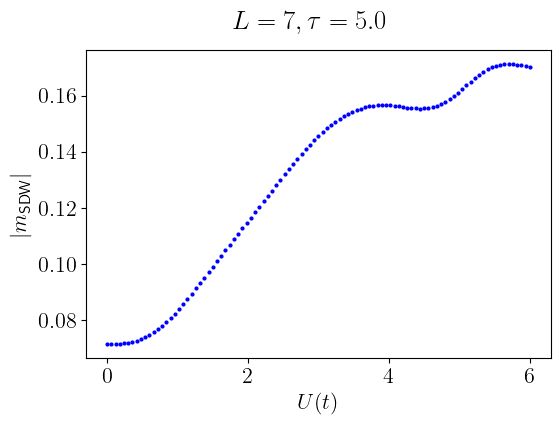

In [ ]:
def m_SDW(L, Sj): 
    m_Sdw = 0
    for j in range(L):
        m_Sdw += (-1)**(j+1) * (Sj[j])
    return m_Sdw / L 

fig, ax = plt.subplots(1,1, figsize=(6,4))

for t in range(N_t):
    m_sdw_t = m_SDW(L, magnetization[t])
    Ut = Drive_Control(ts[t], U_0, U_f, tau)
    ax.plot(Ut, np.abs(m_sdw_t), 'o', markersize=2.0, color="blue")

ax.set_xlabel(r'$U(t)$')
ax.set_ylabel(r'$|m_{\text{SDW}}|$')
plt.suptitle(f"$L = {L}, \\tau = {tau}$")
plt.show()

Nup =  3 NDn =  2
Size of 1D H-space: 100 

2 3 2
reference states: 
array index   /   Fock state   /   integer repr. 
   0.  |1 1 1 0 0>|1 1 0 0 0>  920 
   1.  |1 1 1 0 0>|1 0 1 0 0>  916 
   2.  |1 1 1 0 0>|1 0 0 1 0>  914 
   3.  |1 1 1 0 0>|1 0 0 0 1>  913 
   4.  |1 1 1 0 0>|0 1 1 0 0>  908 
   5.  |1 1 1 0 0>|0 1 0 1 0>  906 
   6.  |1 1 1 0 0>|0 1 0 0 1>  905 
   7.  |1 1 1 0 0>|0 0 1 1 0>  902 
   8.  |1 1 1 0 0>|0 0 1 0 1>  901 
   9.  |1 1 1 0 0>|0 0 0 1 1>  899 
  10.  |1 1 0 1 0>|1 1 0 0 0>  856 
  11.  |1 1 0 1 0>|1 0 1 0 0>  852 
  12.  |1 1 0 1 0>|1 0 0 1 0>  850 
  13.  |1 1 0 1 0>|1 0 0 0 1>  849 
  14.  |1 1 0 1 0>|0 1 1 0 0>  844 
  15.  |1 1 0 1 0>|0 1 0 1 0>  842 
  16.  |1 1 0 1 0>|0 1 0 0 1>  841 
  17.  |1 1 0 1 0>|0 0 1 1 0>  838 
  18.  |1 1 0 1 0>|0 0 1 0 1>  837 
  19.  |1 1 0 1 0>|0 0 0 1 1>  835 
  20.  |1 1 0 0 1>|1 1 0 0 0>  824 
  21.  |1 1 0 0 1>|1 0 1 0 0>  820 
  22.  |1 1 0 0 1>|1 0 0 1 0>  818 
  23.  |1 1 0 0 1>|1 0 0 0 1>  817 
  24.  |1 1 0 0 1

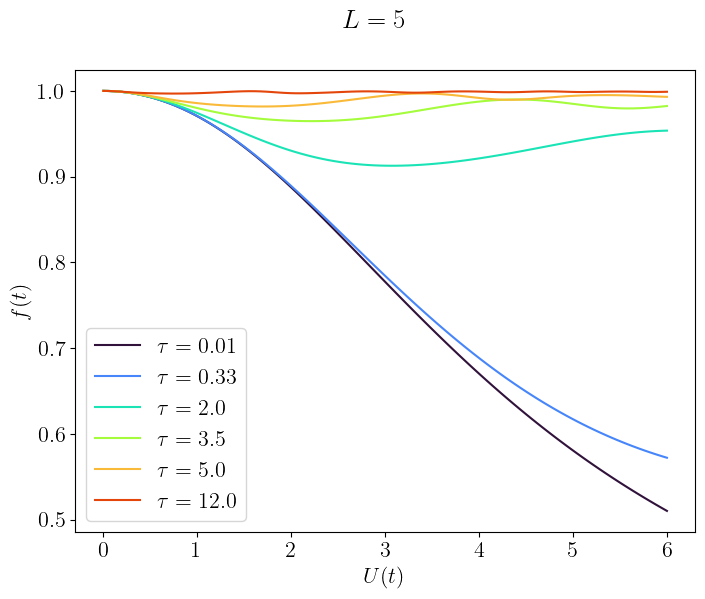

Nup =  4 NDn =  3
Size of 1D H-space: 1225 

3 4 3
reference states: 
array index   /   Fock state   /   integer repr. 
    0.  |1 1 1 1 0 0 0>|1 1 1 0 0 0 0>  15472 
    1.  |1 1 1 1 0 0 0>|1 1 0 1 0 0 0>  15464 
    2.  |1 1 1 1 0 0 0>|1 1 0 0 1 0 0>  15460 
    3.  |1 1 1 1 0 0 0>|1 1 0 0 0 1 0>  15458 
    4.  |1 1 1 1 0 0 0>|1 1 0 0 0 0 1>  15457 
    5.  |1 1 1 1 0 0 0>|1 0 1 1 0 0 0>  15448 
    6.  |1 1 1 1 0 0 0>|1 0 1 0 1 0 0>  15444 
    7.  |1 1 1 1 0 0 0>|1 0 1 0 0 1 0>  15442 
    8.  |1 1 1 1 0 0 0>|1 0 1 0 0 0 1>  15441 
    9.  |1 1 1 1 0 0 0>|1 0 0 1 1 0 0>  15436 
   10.  |1 1 1 1 0 0 0>|1 0 0 1 0 1 0>  15434 
   11.  |1 1 1 1 0 0 0>|1 0 0 1 0 0 1>  15433 
   12.  |1 1 1 1 0 0 0>|1 0 0 0 1 1 0>  15430 
   13.  |1 1 1 1 0 0 0>|1 0 0 0 1 0 1>  15429 
   14.  |1 1 1 1 0 0 0>|1 0 0 0 0 1 1>  15427 
   15.  |1 1 1 1 0 0 0>|0 1 1 1 0 0 0>  15416 
   16.  |1 1 1 1 0 0 0>|0 1 1 0 1 0 0>  15412 
   17.  |1 1 1 1 0 0 0>|0 1 1 0 0 1 0>  15410 
   18.  |1 1 1 1 0 0 0>|0 1 1 0 0 

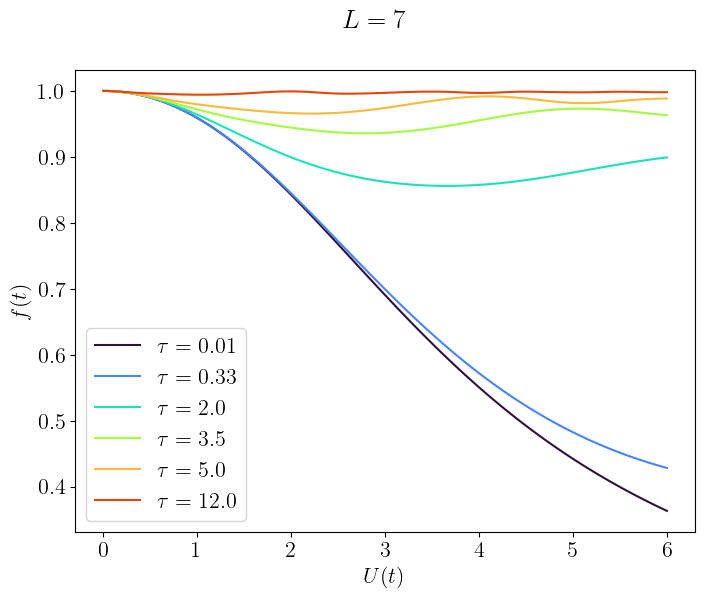

Nup =  5 NDn =  4
Size of 1D H-space: 15876 

4 5 4
reference states: 
array index   /   Fock state   /   integer repr. 
     0.  |1 1 1 1 1 0 0 0 0>|1 1 1 1 0 0 0 0 0>  254432 
     1.  |1 1 1 1 1 0 0 0 0>|1 1 1 0 1 0 0 0 0>  254416 
     2.  |1 1 1 1 1 0 0 0 0>|1 1 1 0 0 1 0 0 0>  254408 
     3.  |1 1 1 1 1 0 0 0 0>|1 1 1 0 0 0 1 0 0>  254404 
     4.  |1 1 1 1 1 0 0 0 0>|1 1 1 0 0 0 0 1 0>  254402 
     5.  |1 1 1 1 1 0 0 0 0>|1 1 1 0 0 0 0 0 1>  254401 
     6.  |1 1 1 1 1 0 0 0 0>|1 1 0 1 1 0 0 0 0>  254384 
     7.  |1 1 1 1 1 0 0 0 0>|1 1 0 1 0 1 0 0 0>  254376 
     8.  |1 1 1 1 1 0 0 0 0>|1 1 0 1 0 0 1 0 0>  254372 
     9.  |1 1 1 1 1 0 0 0 0>|1 1 0 1 0 0 0 1 0>  254370 
    10.  |1 1 1 1 1 0 0 0 0>|1 1 0 1 0 0 0 0 1>  254369 
    11.  |1 1 1 1 1 0 0 0 0>|1 1 0 0 1 1 0 0 0>  254360 
    12.  |1 1 1 1 1 0 0 0 0>|1 1 0 0 1 0 1 0 0>  254356 
    13.  |1 1 1 1 1 0 0 0 0>|1 1 0 0 1 0 0 1 0>  254354 
    14.  |1 1 1 1 1 0 0 0 0>|1 1 0 0 1 0 0 0 1>  254353 
    15.  |1 1 1 1 1 0 0 

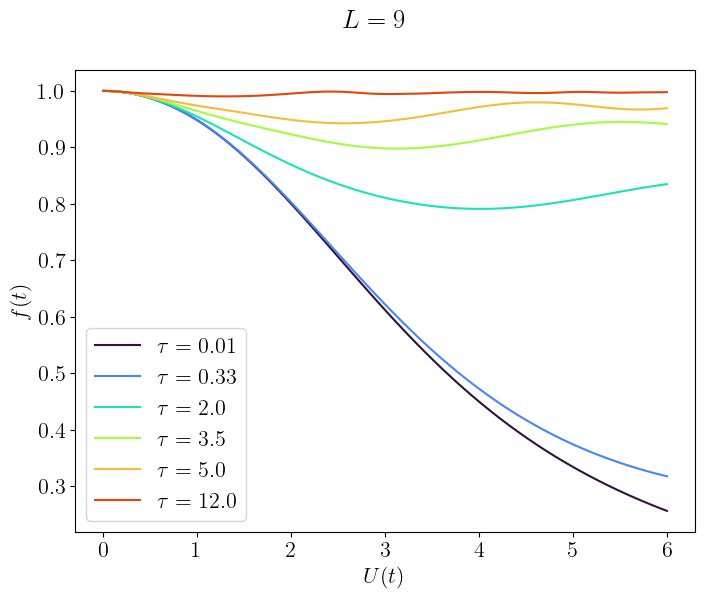

In [ ]:
taus = [0.01, 0.33, 2.0, 3.5, 5.0, 12.0]

Ls = [5, 7, 9] # , 11]

for L in Ls:

    # basis with symmetries
    N = L//2
    N_up = N + L%2
    N_down = L - N_up

    print("Nup = ", N_up,  "NDn = ", N_down)

    basis = spinful_fermion_basis_1d(L,Nf=(N_up,N_down))
    dim=basis.Ns

    print("Size of 1D H-space: {Ns:d} \n".format(Ns=dim))
    print(N, N_up, N_down)
    print(basis)

    H_0 = EHM_Hamiltonian(L, U_0, V_0)

    N_t = 101
    fidelity_t = np.zeros((len(taus), N_t))

    for i, tau in enumerate(taus):

        print(f"Running for tau = {tau}")

        U_t = Quench_U(L, U_0, U_f, tau)

        # Construct time-dependent Hamiltonian
        H_t = hamiltonian(H_0, U_t, basis=basis, dtype=np.float64,  **no_checks)

        E_GS, Psi_GS = H_t.eigsh(time = 0, k=1, which='SA')

        ts = np.linspace(0, tau, N_t)

        Psi_ts = H_t.evolve(Psi_GS,ts[0],ts,rtol=1E-9,atol=1E-9, iterate=False)[:,0,:]

        for t in range(N_t):
            _, Psi_GS_tau = H_t.eigsh(time=ts[t], k=1, which='SA')
            fidelity_t[i, t] = np.abs(np.vdot(Psi_ts[:, t], Psi_GS_tau))**2

    cmap = plt.cm.turbo  

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    for i, tau in enumerate(taus):
        ts = np.linspace(0, tau, N_t)
        Vt = np.array([Drive_Control(t, U_0, U_f, tau) for t in ts])

        color = cmap(i / len(taus)) 
        ax.plot(Vt, fidelity_t[i], color=color, label=f"$\\tau = {tau}$")

    fig.suptitle(f"$L = {L}$") # |\langle \Psi(t) |\Psi_{GS}^{\tau}\rangle|^2$")
    ax.set_xlabel(r'$U(t)$')
    ax.set_ylabel(r'$f(t)$')
    ax.legend()
    plt.show()